# 📚 Embedding Aggregation for Text Classification: TF-IDF vs FastText vs ELMo

In this notebook, we explore how different vectorization strategies impact the performance of a **logistic regression** classifier on the **IMDB** sentiment dataset.  
We will examine:  
- **TF-IDF** bag-of-words  
- **FastText** static word embeddings  
- **ELMo** contextual embeddings  

Our focus is on how to transform **word embeddings** into **sentence embeddings** and how these choices affect classification.

---

## 🧭 Goal

- Implement logistic regression classifiers using three feature types:  
  1. TF-IDF vectors  
  2. FastText word embeddings aggregated into sentence vectors  
  3. ELMo embeddings aggregated into sentence vectors  

- Compare three pooling strategies for embedding-based methods:  
  - **Concatenation** (fixed-length, truncated/padded)  
  - **Mean** pooling  
  - **TF-IDF-weighted mean** pooling  

- Benchmark against native ELMo sentence representations.  
- Analyze differences in word importance between TF-IDF and median-based embeddings.

---

## 📌 Table of Contents

1. Environment Setup & Imports  
2. Data Loading & Preprocessing  
3. TF-IDF Baseline  
4. FastText Embeddings  
   - Loading FastText  
   - Aggregation Strategies  
   - Classification  
5. ELMo Embeddings
6. Model Comparison & Interpretation  
7. Conclusion

---

## 0. 🧠 Introduction

Turning raw text into numerical features is a key step in NLP pipelines. While **TF-IDF** treats each word as an independent feature, **word embeddings** capture semantic relationships but require pooling to create fixed-length sentence vectors.

Pooling strategies can dramatically influence downstream performance:
- **Concatenation** preserves positional information up to a fixed length.  
- **Mean** pooling offers a simple average representation.  
- **TF-IDF-weighted mean** emphasizes more informative words.

**Why this matters:**  
Understanding how pooling choices impact classification helps in selecting appropriate strategies for tasks like sentiment analysis, document retrieval, and beyond.

---

## 1. ⚙️ Environment Setup & Imports

First, we install and import all the libraries we’ll need:

- **Data & Modeling**: `datasets`, `scikit-learn`, `numpy`, `pandas`
- **TF-IDF**: `TfidfVectorizer`
- **FastText**: `huggingface_hub`
- **ELMo**: `tensorflow` and `tensorflow_hub`
- **Classifier**: `LogisticRegression`

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Hugging Face datasets
from datasets import load_dataset

# TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# FastText downloader
from huggingface_hub import hf_hub_download

# TensorFlow & ELMo
import tensorflow as tf
import tensorflow_hub as hub

# Model and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Ensure reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2. 🗄️ Loading & Preprocessing the IMDB Dataset

We'll load the IMDB sentiment dataset from Hugging Face and prepare our train/test splits.

- The dataset has **25,000** labeled movie reviews for training and **25,000** for testing.
- Each example has a `text` field (the review) and a `label` (0 = negative, 1 = positive).
- We'll extract texts and labels into NumPy arrays for downstream feature extraction.

In [2]:
# Load IMDB dataset
imdb = load_dataset("imdb")

# Extract train and test splits
train_texts = imdb["train"]["text"]
train_labels = np.array(imdb["train"]["label"])
test_texts  = imdb["test"]["text"]
test_labels  = np.array(imdb["test"]["label"])

# Quick sanity check
print(f"Train examples: {len(train_texts)}")
print(f"Test  examples: {len(test_texts)}\n")

print("Example review (train):")
print(train_texts[0][:500], "...\n")
print("Label:", train_labels[0])

Train examples: 25000
Test  examples: 25000

Example review (train):
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent ...

Label: 0


## 2bis 🛠️ Evaluation Utilities

Before we dive into TF-IDF vectorization and logistic regression, let's define a helper class to compute and plot our classification metrics (accuracy, precision, recall, F1) for each method we test.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric.capitalize())
            ax.set_ylim(0, 100)

            # Add values on top of bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


## 3. TF-IDF Baseline

In this section, we’ll build our first **extrinsic evaluation**: train a **Logistic Regression** classifier on **TF-IDF** representations of IMDB movie reviews. This will serve as a strong baseline before we move on to embedding-based features.

### 🔧 TF-IDF Vectorization & Model Training

We’ll convert each review into a TF-IDF vector (unigrams + bigrams, capped at 50k features, min_df = 5, stop_words = 'english'), then train a Logistic Regression model.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorize with TF-IDF
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=5, stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf  = tfidf.transform(test_texts)

# Train Logistic Regression
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, train_labels)


LogisticRegression(max_iter=1000)

### 📊 Evaluate on Test Set

Use our `Metrics` helper to compute and plot accuracy, precision, recall, and F1 for the TF-IDF baseline.


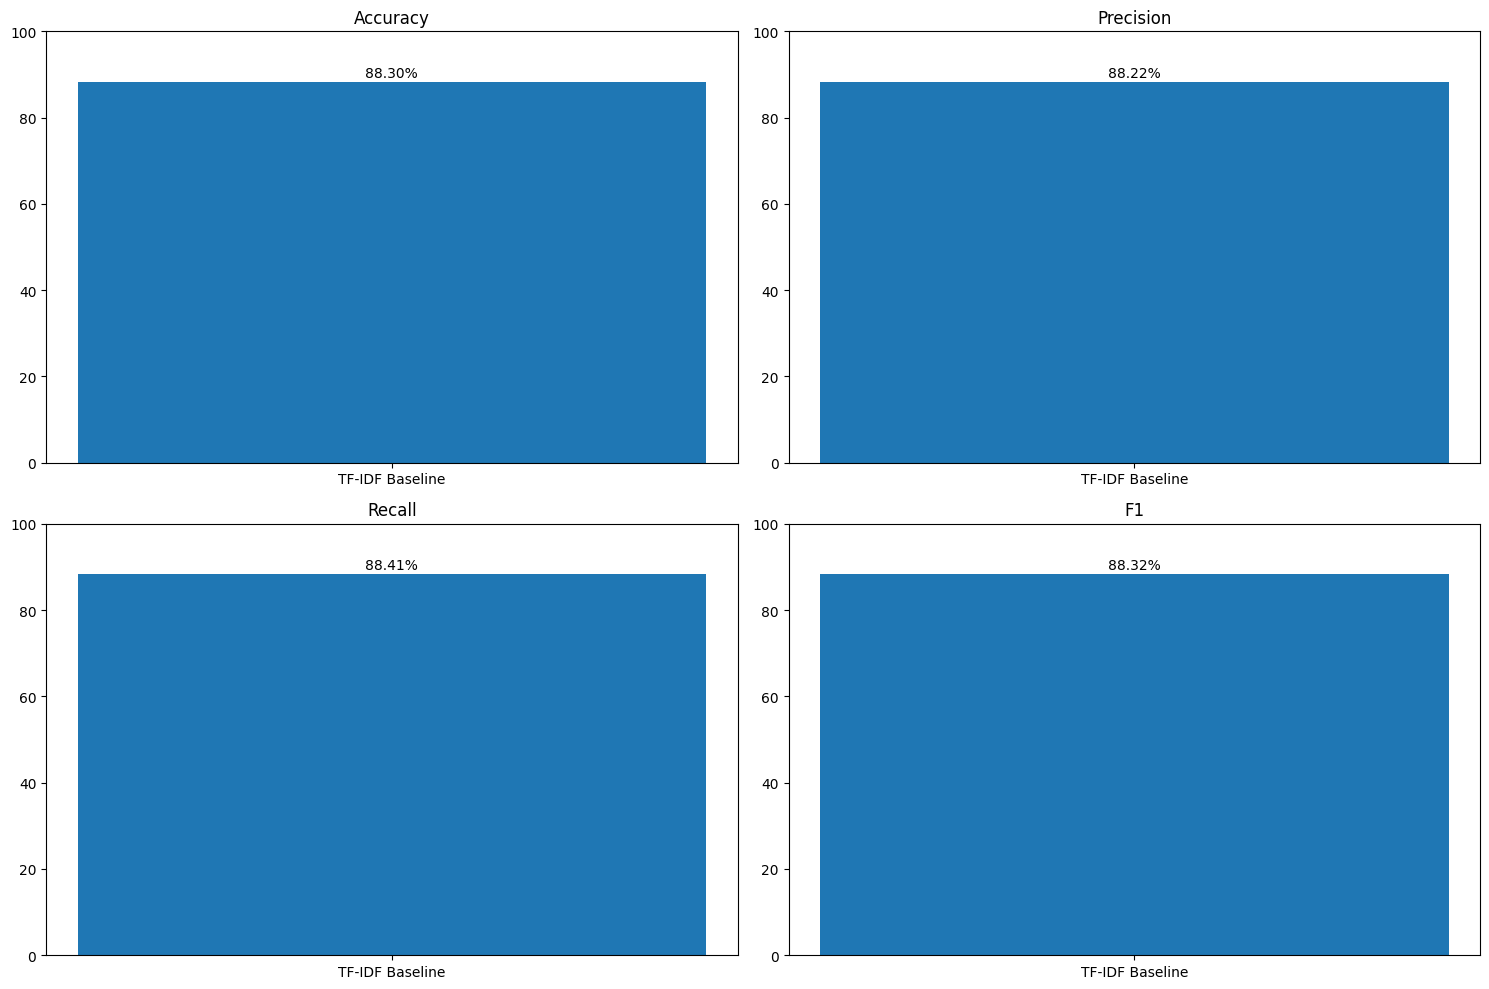

In [14]:
# Predict & evaluate
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

metrics = Metrics()
metrics.run(test_labels, y_pred_tfidf, "TF-IDF Baseline")
metrics.plot()

### ✏️ Quick Comment on TF-IDF Baseline

Our TF-IDF + Logistic Regression baseline achieves **88.30%** across accuracy, precision, recall and F1. This is a strong starting point—showing that simple bag-of-ngrams still captures a lot of sentiment signal in IMDB reviews.  

Now, let’s see how adding **subword information** via FastText embeddings changes our performance!

--- 

## 4. FastText Embedding Features

In this section, we’ll:

1. Load the pre-trained FastText model from Hugging Face.
2. Write helper functions to turn each review into:
   - **Concatenation** of all word vectors
   - **Mean** of word vectors
   - **TF-IDF-weighted average** of word vectors
3. Train a Logistic Regression classifier on each feature set.
4. Compare results against our TF-IDF baseline.


In [6]:
from huggingface_hub import hf_hub_download
import fasttext

# Download & load FastText vectors
fasttext_model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")
ft = fasttext.load_model(fasttext_model_path)

# Example: get vector for a word
print("Vector dim:", ft.get_word_vector("movie").shape)

Vector dim: (300,)


### 🔗 From Word Embeddings to Sentence Embeddings

In our sentiment classification task, each **review** is a whole sentence (or paragraph), but FastText (and other embedding models) give us **one vector per word**. To feed these into a **Logistic Regression** classifier, we need a **fixed-length representation** for each review.  

We'll explore three common strategies to **aggregate** word vectors into a single **sentence embedding**:  
1. **Concatenation** – preserve word order (up to a limit)  
2. **Mean pooling** – simple average of all word vectors  
3. **TF-IDF weighted average** – emphasize important words by weighting  

---

### 📦 FastText Sentence Embedding Strategies

Below are the helper functions we’ll use. They each take a list of raw texts and our FastText model, and output a 2D NumPy array where each row is the sentence embedding for one review.

---

#### 4.1 ✂️ Concatenation of Word Vectors

- **What it does**:  
  1. Split the review into words.  
  2. Fetch each word's FastText vector, up to a fixed maximum length (`max_len`).  
  3. **Concatenate** them in order, padding with zeros if the review is shorter than `max_len`.  
- **Why**: Keeps some sense of word order and fine-grained structure, at the cost of high dimensionality.

---

#### 4.1.2 ⚖️ Mean Pooling of Word Vectors

- **What it does**:  
  1. Split the review into words.  
  2. Fetch each word's vector.  
  3. Compute the **arithmetic mean** across all vectors.  
- **Why**: Produces a compact, order-agnostic summary of the sentence. Often surprisingly effective despite its simplicity.

---

#### 4.1.3 📝 TF-IDF Weighted Average of Word Vectors

- **What it does**:  
  1. Precompute TF-IDF scores for each word in our corpus.  
  2. For each review, split into words and look up each word’s TF-IDF weight.  
  3. Compute a **weighted average** of the FastText vectors, using TF-IDF weights to upweight rare/informative words.  
- **Why**: Balances the simplicity of averaging with a way to emphasize words that carry more sentiment information.

---

Next, we’ll implement these functions in code, generate feature matrices for our train and test sets, and train a Logistic Regression on each to see how they compare!

In [7]:
import scipy.sparse as sp

def ft_concat_embedding(texts, model):
    """Concatenate all word vectors for each text (pads/truncates to max_len)."""
    max_len = 100  # for example
    dims = model.get_word_vector("test").shape[0]
    features = []
    for doc in texts:
        vecs = [model.get_word_vector(w) for w in doc.split()][:max_len]
        # pad with zeros if shorter
        if len(vecs) < max_len:
            vecs.extend([np.zeros(dims)] * (max_len - len(vecs)))
        features.append(np.concatenate(vecs))
    return np.vstack(features)

def ft_mean_embedding(texts, model):
    """Mean of word vectors for each text."""
    features = []
    for doc in texts:
        vecs = np.array([model.get_word_vector(w) for w in doc.split()])
        features.append(vecs.mean(axis=0) if len(vecs) else np.zeros(model.get_word_vector("test").shape))
    return np.vstack(features)

def ft_tfidf_weighted_embedding(texts, model, tfidf_vec, tfidf_matrix):
    """TF-IDF weighted average of word vectors."""
    features = []
    tfidf_vocab = tfidf_vec.vocabulary_
    idf = tfidf_vec.idf_
    for i, doc in enumerate(texts):
        words = doc.split()
        weights = []
        vecs = []
        for w in words:
            if w in tfidf_vocab:
                w_idx = tfidf_vocab[w]
                weights.append(idf[w_idx])
                vecs.append(model.get_word_vector(w))
        if vecs:
            wgt = np.average(np.array(vecs), axis=0, weights=weights)
        else:
            wgt = np.zeros(model.get_word_vector("test").shape)
        features.append(wgt)
    return np.vstack(features)

In [8]:
# Example texts
sample_texts = [
    "This movie was outstanding and full of suspense",
    "I did not enjoy the plot, it was too predictable",
    "An absolute masterpiece with brilliant acting"
]

tfidf_matrix = tfidf.transform(sample_texts) #we already fit the vectorizer on the corpus previously

# 3. Generate embeddings
emb_concat = ft_concat_embedding(sample_texts, ft)
emb_mean   = ft_mean_embedding(sample_texts, ft)
emb_tf     = ft_tfidf_weighted_embedding(sample_texts, ft, tfidf, tfidf_matrix)

# 4. Inspect shapes and a snippet of the first vector
print("Concatenation:", emb_concat.shape, "— first 5 values:", emb_concat[0][:5])
print("Mean pooling:", emb_mean.shape, "— first 5 values:", emb_mean[0][:5])
print("TF-IDF wgt:", emb_tf.shape,   "— first 5 values:", emb_tf[0][:5])

Concatenation: (3, 30000) — first 5 values: [-0.03508458  0.10469877  0.00859013  0.10003099  0.02248639]
Mean pooling: (3, 300) — first 5 values: [-0.0043145  -0.00577394 -0.0089867   0.00266586 -0.00065803]
TF-IDF wgt: (3, 300) — first 5 values: [-0.01418748 -0.00709886  0.03651825  0.03428475  0.01234921]


### 🏗️ Building FastText Pipelines, Training & Evaluation

Now that we have our three sentence‐embedding strategies for FastText, we’ll:

1. **Generate features** for train and test sets via each strategy  
2. **Train a Logistic Regression** on each feature set  
3. **Evaluate** and visualize results with our `Metrics` helper  

This will let us directly compare how concatenation, mean pooling, and TF-IDF‐weighted pooling fare on movie‐review sentiment.

In [10]:
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# 3. Build three pipelines using our embedding functions + logistic regression
pipelines = {
    "FT_Concat": Pipeline([
        ("embed", FunctionTransformer(lambda X: ft_concat_embedding(X, ft), validate=False)),
        ("clf",   LogisticRegression(max_iter=1000))
    ]),
    "FT_Mean": Pipeline([
        ("embed", FunctionTransformer(lambda X: ft_mean_embedding(X, ft), validate=False)),
        ("clf",   LogisticRegression(max_iter=1000))
    ]),
    "FT_TFIDF": Pipeline([
        ("embed", FunctionTransformer(
            lambda X: ft_tfidf_weighted_embedding(X, ft, tfidf, tfidf.transform(X)),
            validate=False
        )),
        ("clf",   LogisticRegression(max_iter=1000))
    ]),
}

for name, pipe in tqdm(pipelines.items()):
    pipe.fit(train_texts, train_labels)

100%|██████████| 3/3 [07:30<00:00, 150.33s/it]


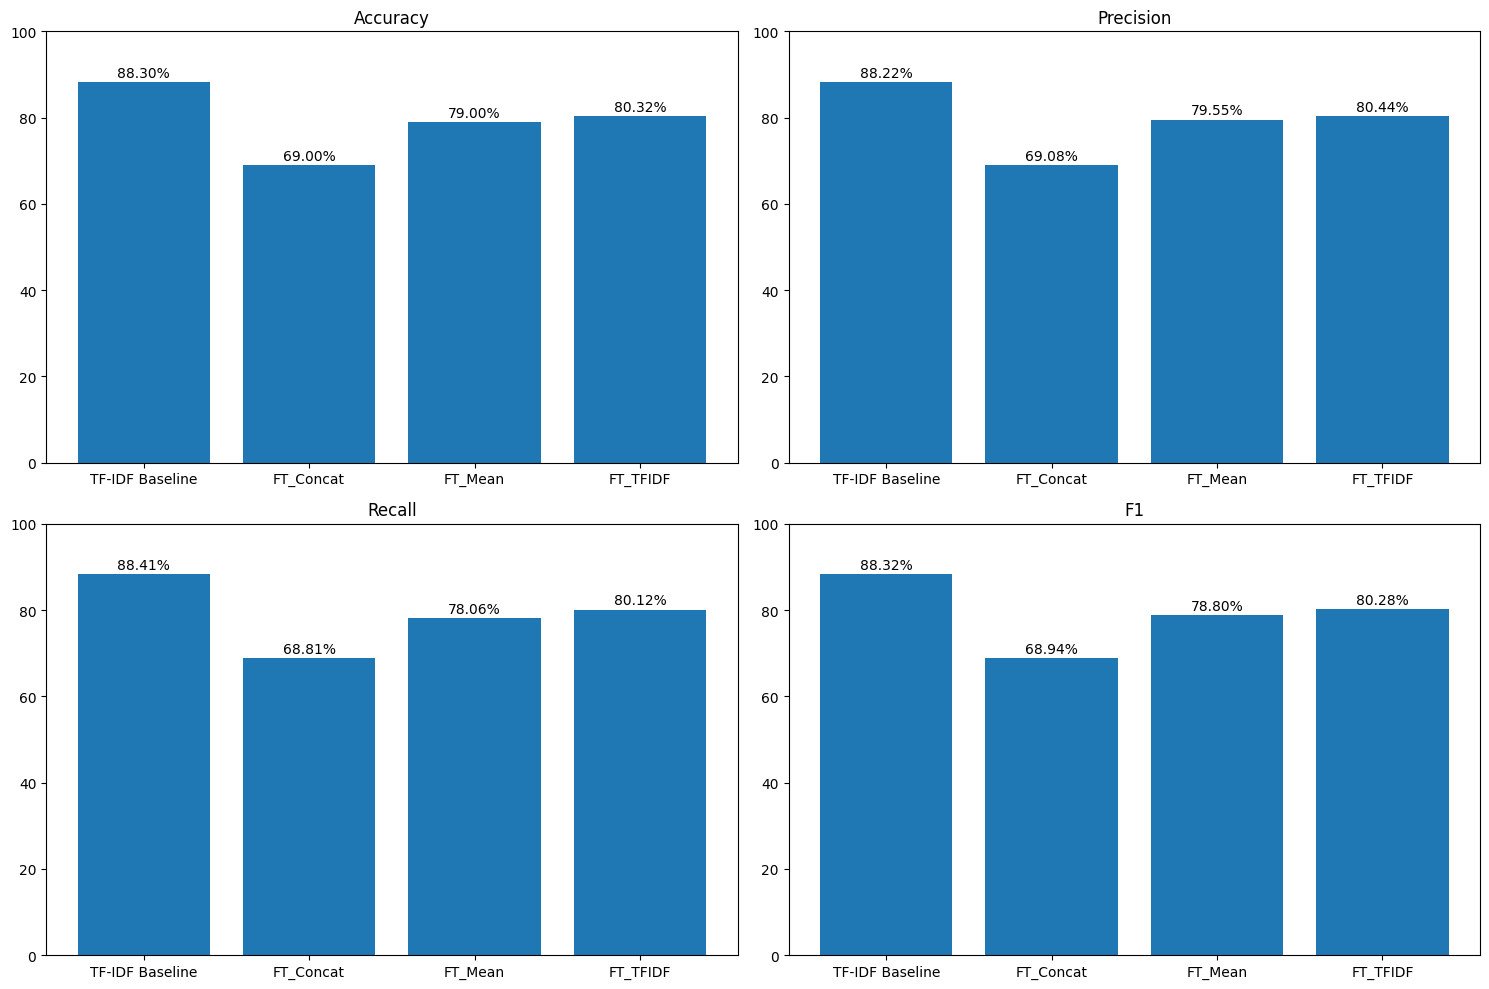

In [15]:
for name, pipe in pipelines.items():    
    preds = pipe.predict(test_texts)
    metrics.run(test_labels, preds, method_name=name)

# 5. Visualize all results
metrics.plot()

### 🧐 Interpreting the FastText Results

Our FastText pipelines yielded the following F1 scores on the IMDB test set:

- **FT_Concat**: 69%  
- **FT_Mean**: 79%  
- **FT_TFIDF**: 80%  
- **TF-IDF Baseline**: 88%

Why do these static‐embedding strategies fall short of a pure TF-IDF model?

1. **Concatenation (69% F1)**  
   Concatenating every word vector up to a fixed length creates a very high‐dimensional feature space.  
   - Every review becomes one enormous vector whose layout depends on word order and padding.  
   - The model must learn to ignore “empty” (zero) slots and discover complex positional patterns.  
   - Signal is diluted by noise—rare words, padding vectors, and varying lengths—making it hard for a simple linear classifier to find a robust decision boundary.

2. **Mean Pooling (79% F1)**  
   Taking the unweighted average of all word vectors collapses the entire review into one compact summary.  
   - This reduces dimensionality and aggregates information, which helps a lot compared to concatenation.  
   - However, **every** word (including stop-words like “the”, “and”, “of”) contributes equally, so irrelevant tokens still dilute your signal.  
   - Word order and local contextual cues are lost—“not good” and “good not” become identical.

3. **TF-IDF-Weighted Pooling (80% F1)**  
   Weighting each word vector by its TF-IDF score improves slightly over the unweighted mean:  
   - High-informativeness words (e.g. “horrible”, “masterpiece”) get more emphasis, while common words get down-weighted.  
   - Yet this still treats the review as a “bag of weighted vectors” with no sense of word adjacency or syntax.  
   - In practice, the marginal gain (<1%) shows that simple linear weighting can only go so far in capturing sentence‐level nuance.

---

🔑 **Key Takeaway:**  
Static word embeddings—whether concatenated, averaged, or TF-IDF-weighted—cannot fully recover the rich structure, negation, and context that a bag-of-words TF-IDF representation already encodes very effectively. In the next section, we’ll see how **contextual models** like ELMo can dynamically adapt to word order and usage, potentially closing this performance gap.

---

## 5. 🌀 Contextual Embeddings with ELMo

ELMo (Embeddings from Language Models) generates **contextualized** word vectors: the same word has different representations depending on its sentence. This lets us capture negation, polysemy, and subtle syntactic cues that static methods miss.

In this section we will:

1. **Load** the pre-trained ELMo model from TensorFlow Hub  
2. **Wrap** it in a scikit-learn transformer that mean-pools over tokens  
3. **Train & evaluate** a logistic regression on these sentence embeddings  

In [32]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.base import BaseEstimator, TransformerMixin

# Load the ELMo model
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

class ELMoTransformer(BaseEstimator, TransformerMixin):
    """A scikit-learn transformer for extracting mean-pooled ELMo embeddings."""
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Process in batches for better performance
        batch_size = 32  # You can adjust this based on your available memory
        num_samples = len(X)
        num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
        
        embeddings_list = []
        
        for i in tqdm(range(num_batches)):
            # Get current batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_texts = X[start_idx:end_idx]
            
            # Process batch
            embedding = self.model.signatures["default"](
                tf.constant(batch_texts)
            )
            
            # Extract embeddings from batch
            batch_embeddings = embedding["default"].numpy()
            embeddings_list.append(batch_embeddings)
        
        # Concatenate all batches
        return np.vstack(embeddings_list)


### 🧪 Example: Using `ELMoTransformer` on a Single Review

Below we take one IMDb review, pass it through our `ELMoTransformer`, and inspect the resulting 1024-dimensional sentence embedding.

In [33]:
# Grab a single test review
single_review = train_texts[0]
print("Raw review text:\n", single_review, "\n")

# Instantiate and transform
elmo_trans = ELMoTransformer(elmo_model)
single_emb = elmo_trans.transform([single_review])

# Inspect the output
print("ELMo embedding shape:", single_emb.shape)
print("First 5 dimensions of embedding:\n", single_emb[0][:5])


Raw review text:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few an

### 🏗️ Building the ELMo Pipeline, Training & Evaluation

We’ll now wire up our `ELMoTransformer` with a `LogisticRegression` in an sklearn `Pipeline`, fit it on the IMDB training set, and evaluate on the test split using our `Metrics` helper.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Assemble the pipeline
elmo_pipe = Pipeline([
    ("elmo", ELMoTransformer(elmo_model)),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train & Predict
elmo_pipe.fit(train_texts, train_labels)
y_elmo = elmo_pipe.predict(test_texts)

In [ ]:
# Evaluate
metrics.run(test_labels, y_elmo, "ELMo")
metrics.plot()